# C51 implementation.

Qlearning with Distributional RL

Original paper:
https://arxiv.org/pdf/1707.06887.pdf

In [1]:
# # in google colab uncomment this

# import os

# os.system('apt-get install -y xvfb')
# os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
# os.system('apt-get install -y python-opengl ffmpeg')
# os.system('pip install pyglet==1.2.4')

# os.system('python -m pip install -U pygame --user')

# prefix = 'https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/'

# os.system('wget ' + prefix + 'atari_wrappers.py')
# os.system('wget ' + prefix + 'utils.py')
# os.system('wget ' + prefix + 'replay_buffer.py')
# os.system('wget ' + prefix + 'framebuffer.py')

# print('setup complete')

# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

In [2]:
import random
import numpy as np
import torch
import utils

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt

### CartPole Env

In [4]:
ENV_NAME = 'CartPole-v1'

def make_env(seed=None):
    # CartPole is wrapped with a time limit wrapper by default
    env = gym.make(ENV_NAME).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

In [5]:
env = make_env()
env.reset()
state_shape, n_actions = env.observation_space.shape, env.action_space.n
print(state_shape, n_actions)

(4,) 2


### Building a network

In [6]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# those who have a GPU but feel unfair to use it can uncomment:
# device = torch.device('cpu')
device

device(type='cpu')

In [7]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions,n_atoms,vmin,vmax, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        self.n_atoms = n_atoms
        self.vmin = vmin
        self.vmax = vmax
        self.support = torch.linspace(self.vmin,self.vmax,self.n_atoms).to(device)
        # Define your network body here. Please make sure agent is fully contained here
        assert len(state_shape) == 1
        state_dim = state_shape[0]
        
        self.network = nn.Sequential().to(device)
        self.network.add_module('layer1',nn.Linear(state_dim,256))
        self.network.add_module('relu1',nn.ReLU())
        self.network.add_module('layer2',nn.Linear(256,64))
        self.network.add_module('relu2',nn.ReLU())
        self.network.add_module('layer3',nn.Linear(64,n_actions*n_atoms))
        '''
        Returns shape:  Batch x n_actions x no_of atoms
        '''
        
        
    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch states, shape = [batch_size, *state_dim=4]
        """
        # Use your network to compute qvalues for given state
        logits = self.network(state_t)
        batch_size =logits.shape[0]
        # Apply soft max to get probability
        prob_dist = torch.softmax(logits.view(batch_size,n_actions,n_atoms),dim=2)
        return prob_dist

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float32)
        q_dist = self.forward(states)#.data.cpu().numpy()
        '''
        Expectation of a pob mass func = Probability of x * x
        q values = expectation over each actoin distributuion
        '''
        qvalues = (q_dist*self.support).sum(2)
        return qvalues.detach().numpy(),q_dist

    def sample_actions(self, q_values):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        #print(q_values.shape)
        batch_size, n_actions = q_values.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        #print(q_values)
        best_actions = q_values.argmax(axis=-1)
        #print('Best Actions:',best_actions)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)
    
    def get_distribution(self,states,actions):
        qvalues, distr = self.get_qvalues(states)
        #distr :Batchsize x nActions x nAtoms
        #actions = self.sample_actions(qvalues)
        distr_actions = distr[torch.arange(len(distr)),actions] #Batchsize x nAtoms
        return distr_actions
        
        

### Code for Evaluation

In [8]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues,_ = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [9]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    for i in range (n_steps):
        qvalues,_ = agent.get_qvalues([s])
        #action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
        action = agent.sample_actions(qvalues)[0]
        next_s, r, done, _ = env.step(action)
        sum_rewards += r
        exp_replay.add(s, action, r, next_s, done)
        s = next_s
        if done:
            s = env.reset()

    return sum_rewards, s

#### Linear scheduling

In [10]:
def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope =  (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)


### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

In [11]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float)    # shape: [batch_size, *state_shape]

    # for some torch reason should not make actions a tensor
    actions = torch.tensor(actions, device=device, dtype=torch.long)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float).unsqueeze(-1)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float
    ).unsqueeze(-1)  # shape: [batch_size]
    is_not_done = 1 - is_done
    
    with torch.no_grad():
        
        # compute q-values for all actions in next states
        next_state_qvals,next_distr = target_network.get_qvalues(next_states)
        best_actions = next_state_qvals.argmax(axis=-1)
        next_state_distr = next_distr[torch.arange(len(next_distr)),best_actions]
        
        #next_state_pmfs = target_network.get_distribution(next_states)
        nextstate_support = rewards + (gamma* agent.support *is_not_done)

        #Projection
        delta_z = float(agent.vmax-agent.vmin)/(agent.n_atoms-1.)
        tz = nextstate_support.clamp(agent.vmin,agent.vmax)
        b = (tz-agent.vmin)/delta_z

        l = b.floor().clamp(0,agent.n_atoms-1)
        u = b.ceil().clamp(0,agent.n_atoms-1)

        d_m_l = (u+(l==u).float()-b)*next_state_distr
        d_m_u = (b - l) * next_state_distr

        target_pmfs = torch.zeros_like(next_state_distr)

        for i in range(target_pmfs.size(0)):
            target_pmfs[i].index_add_(0, l[i].long(), d_m_l[i])
            target_pmfs[i].index_add_(0, u[i].long(), d_m_u[i])
            
    #state_pmfs-> shape : Batchsize x nAtoms        
    state_pmfs = agent.get_distribution(states,actions)
    
    loss = (-1*(target_pmfs.detach()*state_pmfs.log()).sum(-1)).mean()

    return loss

Sanity checks

### Main loop

It's time to put everything together and see if it learns anything.

In [12]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [13]:
seed = 47
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [14]:
env = make_env(seed)
state_dim = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

n_atoms =101
vmin=-50
vmax=50

agent = DQNAgent(state_dim, n_actions,n_atoms,vmin,vmax, epsilon=0.8).to(device)

target_network = DQNAgent(agent.state_shape, agent.n_actions,\
                          agent.n_atoms,agent.vmin,agent.vmax,epsilon=0.8).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [15]:
from replay_buffer import ReplayBuffer
timesteps_per_epoch = 1
batch_size = 32
total_steps = 10**5
decay_steps = 8 * 10**4

exp_replay = ReplayBuffer(10**5)

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.5

loss_freq = 20
refresh_target_network_freq = 1000
eval_freq = 1000

max_grad_norm = 5000

In [16]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

buffer size = 100000, epsilon = 0.50000


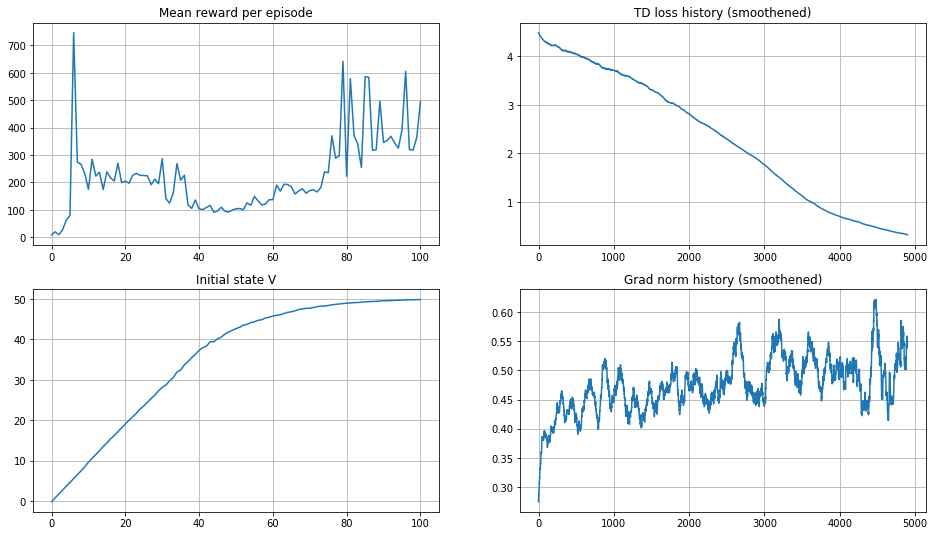

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100001/100001 [15:47<00:00, 105.54it/s]


In [17]:
state = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('less that 100 Mb RAM available, freezing')
        print('make sure everything is ok and make KeyboardInterrupt to continue')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)
    target_network.epsilon = agent.epsilon

    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train
    #< sample batch_size of data from experience replay >
    obs,act,rw,next_obs,is_done = exp_replay.sample(batch_size)

    loss = compute_td_loss(obs, act, rw, next_obs, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm)

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        #target_network.parameters() = agent.parameters()
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        # eval the agent
        mean_rw_history.append(evaluate(
            make_env(seed=step), agent, n_games=3, greedy=True, t_max=1000)
        )
        initial_state_q_values,_ = agent.get_qvalues(
            [make_env(seed=step).reset()]
        )
        initial_state_v_history.append(np.max(initial_state_q_values))

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])
        plt.subplot(2, 2, 1)
        plt.title("Mean reward per episode")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        plt.show()

In [18]:
final_score = evaluate(
  make_env(),
  agent, n_games=30, greedy=True, t_max=1000
)
print('final score:', final_score)
assert final_score > 300, 'not good enough for DQN'
print('Well done')

final score: 491.8666666666667
Well done
